<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style = "border:2px solid black" ></hr>


**What?** Locality Sensitive Hashing (LSH) - Cosine Distance



# Import modules
<hr style = "border:2px solid black" ></hr>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Locality Sensitive Hashing (LSH) - Cosine Distance
<hr style = "border:2px solid black" ></hr>


- Similarity search is a widely used and important method in many applications. One example is [Shazam](https://www.shazam.com/), the app that let's us identify can song within seconds is leveraging audio fingerprinting and most likely a fast and scalable similarity search method to retrieve the relevant song from a massive database of songs. 

- **Locality Sensitive Hashing (LSH)**, an approximate nearest neighborhood search technique in the context of recommendation system. Note that, Locality Sensitive 

- Hashing (LSH) is **actually** a family of algorithm, different distance metric will correspond to a different method. Here we will be focusing on cosine distance.



## Content-Based Filtering

In the realm of recommender system, collaborative filtering methods such as matrix factorization are often times workhorse methods of choice. The main idea behind collaborative filtering is that the product you are most likely to buy, is the product that a bunch of people like you also bought. The input to the algorithm is basically a matrix of user IDs and product IDs with values representing who bought what product. Albeit an extremely powerful method, it does suffer from what is known as the cold-start problem.

Let's say we want to make recommendations to a customer viewing a product details page, who just got there from a Google SERP link. We have no historical record about this customer, so we can't build a matrix of purchases. This is where a different approach, so called content-based filtering/recommendation can be helpful.

When we say content-based filtering, we are referring to the fact that we're using items or users' meta-data to generate the recommendation. For example, say the product page that this user landed on is "Nike Pro Hypercool Fitted Men's Compression Shirt", then we can leverage information such as the item's description, price or other attribute to generate recommendation saying you might also love the item "Nike Pro Hypercool Printed Men's Tights".

The dataset that we'll be working with here is a sample data consisting of outdoor clothing and products from Patagonia. It only consists of two columns, the IDs and the product's text description. To leverage this information, we will transform the raw text into a tfidf-format, and use the tf-idf representation to find similar items for a given item (the most similar items to the item we're interested in is essentially our recommended items).

In [2]:
input_local_path = './sample-data-LSH.csv'
df = pd.read_csv(input_local_path)
print('dimension: ', df.shape)
df.head()

dimension:  (500, 2)


,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 3),
    min_df=0,
    stop_words='english')
X_tfidf = tfidf.fit_transform(df['description'])
X_tfidf

<500x52262 sparse matrix of type '<class 'numpy.float64'>'
	with 148989 stored elements in Compressed Sparse Row format>

In [4]:
def get_similarity_items(X_tfidf, item_id, topn=5):
    """
    Get the top similar items for a given item id.
    The similarity measure here is based on cosine distance.
    """
    query = X_tfidf[item_id]
    scores = X_tfidf.dot(query.T).toarray().ravel()
    best = np.argpartition(scores, -topn)[-topn:]
    return sorted(zip(best, scores[best]), key=lambda x: -x[1])


similar_items = get_similarity_items(X_tfidf, item_id=1)

# an item is always most similar to itself, in real-world
# scenario we might want to filter itself out from the output
for similar_item, similarity in similar_items:
    item_description = df.loc[similar_item, 'description']
    print('similar item id: ', similar_item)
    print('cosine similarity: ', similarity)
    print('item description: ', item_description)
    print()

similar item id:  1
cosine similarity:  1.0000000000000029
item description:  Active sport boxer briefs - Skinning up Glory requires enough movement without your boxers deciding to poach their own route. The form-fitting Active Sport Boxer Briefs are made from breathable 93% polyester (71% recycled) fabric that's fast-wicking, dries quickly and has 7% spandex for stretch; the seamless waistband and soft leg edges won't roll or bind. The gusseted, flat-sewn 6" inseam (size M) is offset to prevent inner-thigh chafe. Fly-free with a smooth front panel. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Stretch mesh provides support, open-weave mesh for airflow, wicks efficiently, dries fast"</li> <li>Seamless construction</li> <li>"Flat-sewn, gusseted inseam is set forward to prevent inner-thigh chafe"</li> <li>Fly-free support</li> <li>"Inseam (size M) is 6"""</li></ul><br><br><b>Fabric: </b>"4.6-oz 93% polyester (71% recycled)/7% spandex, with moist

Hopefully, we can sort of agree that the result reflects our intuition. Given a item, Active sport boxer briefs, the content-based filtering method based on the item's description in tfidf-representation recommends items such as Active sport briefs, Cap 1 boxer briefs which are all underwear-related products.

To generate the similar items, the approach we're using here is calculating the cosine distance between our query item and all the other items in our data, then sorting the distance to find the most similar items. This approach might work well for a small dataset, however, as we can imagine this procedure might become a bottleneck to our system as the data points starts to increase, and in near-real time systems where there's a strict latency requirements, this method is most likely not going to cut it.

## Getting Started with LSH

The idea behind LSH is to throw down random lines/vectors. Yes, you are reading it correctly. Then everything that falls below this line has a negative score and will fall into what we'll be referring to as bin 0. On the other hand, everything that's above this line has a positive score and all of those points will be assigned to bin 1. So we're essentially translating the sign of the scores into a binary index. 

For example, in the picture above, the orange data point falls above the random vector and we'll label it as a white bin. Then we can use this for nearest neighbor search in the following way: Given a query data point, say it also falls above the random vector, then we will only search for the nearest neighbor amongst the data points that also fall above the random vector, or another way to put it, we will only search amongst the data points that also fall under the same bin.

If we think about this carefully, the main rationale behind locality sensitive hashing is data points that are located close to each other should be mapped to similar hashes (in same bin/bucket with high probability). i.e. in our made-up example, data points that are close to the orange data point should fall in the same bin, whereas data points that are far away should fall in different bin. However, because of the randomness, it is not likely that all similar items are grouped correctly. Hence, to overcome this limitation, a common practice is to create multiple random vectors.

e.g. Say we throw down another random vector, this time the orange data point falls under this random vector, thus it falls under a different bin (black bin instead of white).


Since, each bin is represented by a bitwise hash value, which is a number made up of a sequence of 1s and 0s. e.g. for this orange data point, if we consider the white bin as 0 and the black bin as 1, then this data point's bin will be represented by [0, 1].

Let's use some code to illustrate this process. Our first step is to generate a collection of random vectors from the standard Gaussian distribution.

In [5]:
def generate_random_vectors(dim, n_vectors):
    """
    generate random projection vectors
    the dims comes first in the matrix's shape,
    so we can use it for matrix multiplication.
    """
    return np.random.randn(dim, n_vectors)

We now generate random vectors of the same dimensionality as our vocabulary size.  Each vector can be used to compute one bit in the bin encoding. We generate 16 vectors, leading to a 16-bit encoding of the bin index for each document. Note that 16 is a hyperparamter, we will look into this adjustable parameter in later section.

In [6]:
vocab_size = len(tfidf.get_feature_names())
print('vocabulary size: ', vocab_size)

np.random.seed(0)
n_vectors = 16
random_vectors = generate_random_vectors(vocab_size, n_vectors)
print('dimension: ', random_vectors.shape)
random_vectors

vocabulary size:  52262
dimension:  (52262, 16)


array([[ 1.76405235,  0.40015721,  0.97873798, ...,  0.12167502,
         0.44386323,  0.33367433],
       [ 1.49407907, -0.20515826,  0.3130677 , ...,  1.46935877,
         0.15494743,  0.37816252],
       [-0.88778575, -1.98079647, -0.34791215, ..., -0.4380743 ,
        -1.25279536,  0.77749036],
       ...,
       [-0.13430852, -2.40513172, -0.15499143, ..., -0.6048063 ,
        -0.10716926, -0.25638226],
       [ 2.67330814,  0.87243643, -0.12795915, ...,  0.82403241,
         1.4171818 ,  0.81563705],
       [-0.38178352,  2.22187987, -0.6359808 , ...,  0.50846758,
         1.50555612,  0.22746407]])

Next, we'd like to decide which bin each documents should go. Since 16 random vectors were generated in the previous cell, we have 16 bits to represent the bin index. The first bit is given by the sign of the dot product between the first random vector and the document's TF-IDF vector, and so on.

In [7]:
# use one data point's tfidf representation as an example
data_point = X_tfidf[0]

# True if positive sign; False if negative sign
bin_indices_bits = data_point.dot(random_vectors) >= 0
print('dimension: ', bin_indices_bits.shape)
bin_indices_bits

dimension:  (1, 16)


array([[False, False, False, False, False, False,  True,  True,  True,
        False, False,  True, False, False, False, False]])

All documents that obtain exactly this vector will be assigned to the same bin. One further preprocessing step we'll perform is to convert this resulting bin into integer representation. This makes it convenient for us to refer to individual bins. 

```
Bin index                      integer
[0,0,0,0,0,0,0,0,0,0,0,0]   => 0
[0,0,0,0,0,0,0,0,0,0,0,1]   => 1
[0,0,0,0,0,0,0,0,0,0,1,0]   => 2
[0,0,0,0,0,0,0,0,0,0,1,1]   => 3
...
[1,1,1,1,1,1,1,1,1,1,0,0]   => 65532
[1,1,1,1,1,1,1,1,1,1,0,1]   => 65533
[1,1,1,1,1,1,1,1,1,1,1,0]   => 65534
[1,1,1,1,1,1,1,1,1,1,1,1]   => 65535 (= 2^16-1)
```

By the [rules of binary number representation](https://en.wikipedia.org/wiki/Binary_number#Decimal), to perform the conversion, we can compute the dot product between the document vector and the vector consisting of powers of 2:

In [8]:
bin_indices_bits = data_point.dot(random_vectors) >= 0

# https://wiki.python.org/moin/BitwiseOperators
# x << y is the same as multiplying x by 2 ** y
powers_of_two = 1 << np.arange(n_vectors - 1, -1, step=-1)
print(powers_of_two)

# final integer representation of individual bins
bin_indices = bin_indices_bits.dot(powers_of_two)
print(bin_indices)

[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[912]


We can repeat the identical operation on all documents in our dataset and compute the corresponding bin. We'll again leverage matrix operations so that no explicit loop is needed.

In [9]:
# we can do it for the entire corpus
bin_indices_bits = X_tfidf.dot(random_vectors) >= 0
print(bin_indices_bits.shape)
bin_indices = bin_indices_bits.dot(powers_of_two)
bin_indices.shape

(500, 16)


(500,)

The resulting array gives us the integer index of the bins for all documents.

Now we are ready to complete the following function. Given the integer bin indices for the documents, we would curate the list of document IDs that belong to each bin. Since a list is to be maintained for each unique bin index, a dictionary of lists is used.

In [10]:
from collections import defaultdict


def train_lsh(X_tfidf, n_vectors, seed=None):    
    if seed is not None:
        np.random.seed(seed)

    dim = X_tfidf.shape[1]
    random_vectors = generate_random_vectors(dim, n_vectors)  

    # partition data points into bins,
    # and encode bin index bits into integers
    bin_indices_bits = X_tfidf.dot(random_vectors) >= 0
    powers_of_two = 1 << np.arange(n_vectors - 1, -1, step=-1)
    bin_indices = bin_indices_bits.dot(powers_of_two)

    # update `table` so that `table[i]` is the list of document ids with bin index equal to i
    table = defaultdict(list)
    for idx, bin_index in enumerate(bin_indices):
        table[bin_index].append(idx)
    
    # note that we're storing the bin_indices here
    # so we can do some ad-hoc checking with it,
    # this isn't actually required
    model = {'table': table,
             'random_vectors': random_vectors,
             'bin_indices': bin_indices,
             'bin_indices_bits': bin_indices_bits}
    return model


# train the model
n_vectors = 16
model = train_lsh(X_tfidf, n_vectors, seed=143)

After generating our LSH model, let's examine the generated bins to get a deeper understanding of them. Recall that during the background section, given a product's tfidf vector representation, we were able to find its similar product using standard cosine similarity. Here, we will look at these similar products' bins to see if the result matches intuition. Remember the idea behind LSH is that similar data points will tend to fall into nearby bins.

In [11]:
# comparison
similar_item_ids = [similar_item for similar_item, _ in similar_items]
bits1 = model['bin_indices_bits'][similar_item_ids[0]]
bits2 = model['bin_indices_bits'][similar_item_ids[1]]

print('bits 1: ', bits1)
print('bits 2: ', bits2)
print('Number of agreed bins: ', np.sum(bits1 == bits2))

bits 1:  [ True False False  True  True  True  True False False  True  True False
 False  True  True False]
bits 2:  [ True False False False False False  True False False  True False False
  True  True  True False]
Number of agreed bins:  11


In [12]:
# comparison
bits1 = model['bin_indices_bits'][similar_item_ids[0]]
bits2 = model['bin_indices_bits'][similar_item_ids[4]]

print('bits 1: ', bits1)
print('bits 2: ', bits2)
print('Number of agreed bins: ', np.sum(bits1 == bits2))

bits 1:  [ True False False  True  True  True  True False False  True  True False
 False  True  True False]
bits 2:  [False  True  True False False  True  True False  True False False False
 False False  True  True]
Number of agreed bins:  6


Looking at the result above, it does seem like LSH is doing what its intended to do: i.e., similar data points will agree upon more bin indices than dissimilar data points, however, in a high-dimensional space such as text features, we can get unlucky with our selection of only a few random vectors such that dissimilar data points go into the same bin while similar data points fall into different bins. Hence, given a query document, we should consider all documents in the nearby bins and sort them according to their actual distances from the query.

## Querying the LSH model

Let's first implement the logic for searching nearby neighbors, which goes like this:


1. Let L be the bit representation of the bin that contains the query documents.
2. Consider all documents in bin L.
3. Consider documents in the bins whose bit representation differs from L by 1 bit.
4. Consider documents in the bins whose bit representation differs from L by 2 bits, and so on ...


To obtain candidate bins that differ from the query bin by some number of bits, we use `itertools.combinations`, which produces all possible subsets of a given list. See [this documentation](https://docs.python.org/3/library/itertools.html#itertools.combinations) for details.


1. Decide on the search radius r. This will determine the number of different bits between the two vectors.
2. For each subset (n_1, n_2, ..., n_r) of the list [0, 1, 2, ..., n_vectors-1], do the following:
   * Flip the bits (n_1, n_2, ..., n_r) of the query bin to produce a new bit vector.
   * Fetch the list of documents belonging to the bin indexed by the new bit vector.
   * Add those documents to the candidate set.

In [13]:
from itertools import combinations


def search_nearby_bins(query_bin_bits, table, search_radius=3, candidate_set=None):
    """
    For a given query vector and trained LSH model's table
    return all candidate neighbors with the specified search radius.
    
    Example
    -------
    model = train_lsh(X_tfidf, n_vectors=16, seed=143)
    query = model['bin_index_bits'][0]  # vector for the first document
    candidates = search_nearby_bins(query, model['table'])
    """
    if candidate_set is None:
        candidate_set = set()

    n_vectors = query_bin_bits.shape[0]
    powers_of_two = 1 << np.arange(n_vectors - 1, -1, step=-1)

    for different_bits in combinations(range(n_vectors), search_radius):
        # flip the bits (n_1, n_2, ..., n_r) of the query bin to produce a new bit vector
        index = list(different_bits)
        alternate_bits = query_bin_bits.copy()
        alternate_bits[index] = np.logical_not(alternate_bits[index])

        # convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)

        # fetch the list of documents belonging to
        # the bin indexed by the new bit vector,
        # then add those documents to candidate_set;
        # make sure that the bin exists in the table
        if nearby_bin in table:
            candidate_set.update(table[nearby_bin])

    return candidate_set

The next code chunk uses this searching for nearby bins logic to search for similar documents and return a dataframe that contains the most similar data points according to LSH and their corresponding distances.

In [14]:
from sklearn.metrics.pairwise import pairwise_distances


def get_nearest_neighbors(X_tfidf, query_vector, model, max_search_radius=3):
    table = model['table']
    random_vectors = model['random_vectors']

    # compute bin index for the query vector, in bit representation.
    bin_index_bits = np.ravel(query_vector.dot(random_vectors) >= 0)

    # search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in range(max_search_radius + 1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, candidate_set)

    # sort candidates by their true distances from the query
    candidate_list = list(candidate_set)
    candidates = X_tfidf[candidate_list]
    distance = pairwise_distances(candidates, query_vector, metric='cosine').flatten()
    
    distance_col = 'distance'
    nearest_neighbors = pd.DataFrame({
        'id': candidate_list, distance_col: distance
    }).sort_values(distance_col).reset_index(drop=True)
    return nearest_neighbors

In [15]:
print('original similar items:\n' + str(similar_items))

item_id = 1
query_vector = X_tfidf[item_id]
nearest_neighbors = get_nearest_neighbors(X_tfidf, query_vector, model, max_search_radius=5)
print('dimension: ', nearest_neighbors.shape)
nearest_neighbors.head()

original similar items:
[(1, 1.0000000000000029), (2, 0.4181663992161579), (18, 0.11546382098627586), (493, 0.11303392245400203), (299, 0.11247854521091638)]
dimension:  (67, 2)


,id,distance
0,1,2.220446e-16
1,2,5.818336e-01
2,317,9.008780e-01
3,213,9.117783e-01
4,272,9.173818e-01


We can observe from the result above that when we use a max_search_radius of 5, our LSH-based similarity search wasn't capable of retrieving the actual most similar items to our target data point, this is expected as we have mentioned LSH is an approximate nearest neighborhood search method. However, if we were to increase the radius parameter to 10, we can in fact retrieve all the actual most similar items.

In [16]:
nearest_neighbors = get_nearest_neighbors(X_tfidf, query_vector, model, max_search_radius=10)
print('dimension: ', nearest_neighbors.shape)
nearest_neighbors.head()

dimension:  (455, 2)


,id,distance
0,1,2.220446e-16
1,2,5.818336e-01
2,18,8.845362e-01
3,493,8.869661e-01
4,299,8.875215e-01


In [17]:
# we can perform a join with the original table to get the description
# for sanity checking purpose
nearest_neighbors.head().merge(df, on='id', how='inner')

,id,distance,description
0,1,2.220446e-16,Active classic boxers - There's a reason why o...
1,2,5.818336e-01,Active sport boxer briefs - Skinning up Glory ...
2,18,8.845362e-01,Cap 1 bottoms - Spring skiing is as transient ...
3,493,8.869661e-01,'73 logo t-shirt - Patagonia's timeless '73 Lo...
4,299,8.875215e-01,Active boy shorts - We've worn these versatile...


## Experimenting with LSH

In the following sections we have implemented a few experiments so we can gain some intuition as to how LSH behaves in different situations. This will help us understand the effect of searching nearby bins and the performance of LSH versus computing nearest neighbors using a brute force search.

The first experiment that we'll be looking at is the **effect of nearby bin search**.

How does nearby bin search affect the three variables that are tied to the search radius:

- Number of candidate documents considered
- Query time
- Distance of approximate neighbors from the query

Let's run LSH multiple times, each with different radius for nearby bin search. We will keep track of the three variables that were discussed above.

In [18]:
import time

query_time_history = []
num_candidates_history = []
max_distance_history = []
min_distance_history = []
average_distance_history = []

topn = 5
query_vector = X_tfidf[1]
for max_search_radius in range(12):
    start = time.time()  
    nearest_neighbors = get_nearest_neighbors(X_tfidf, query_vector, model, max_search_radius)
    end = time.time()
    query_time = end - start

    # the closest neighbor is the query point itself, thus
    # we'll exclude it from the calculation
    distances = nearest_neighbors['distance'].iloc[1:].head(topn)
    max_distance = distances.max()
    min_distance = distances.min()
    average_distance = distances.mean()
    num_candidates = nearest_neighbors.shape[0]

    query_time_history.append(query_time)
    num_candidates_history.append(num_candidates) 
    max_distance_history.append(max_distance)
    min_distance_history.append(min_distance)
    average_distance_history.append(average_distance)

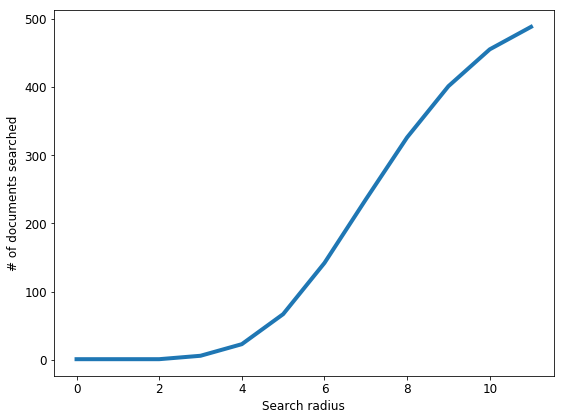

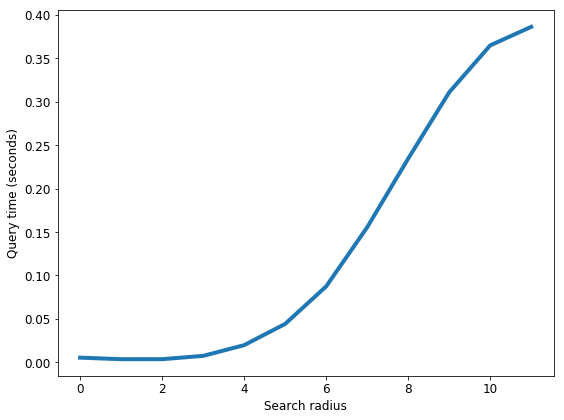

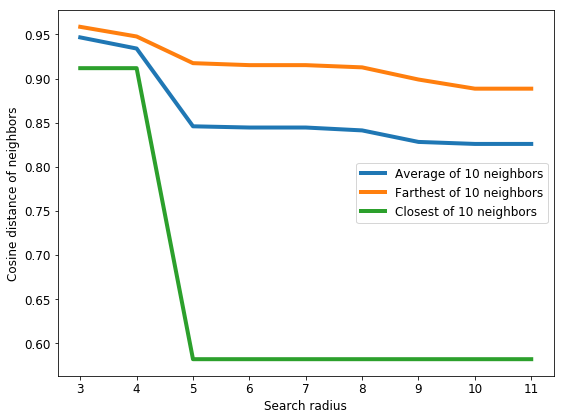

In [19]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12


linewidth = 4
plt.figure()
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.tight_layout()

plt.figure()
plt.plot(query_time_history, linewidth=linewidth)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.tight_layout()

plt.figure()
plt.plot(average_distance_history, linewidth=linewidth, label='Average of 10 neighbors')
plt.plot(max_distance_history, linewidth=linewidth, label='Farthest of 10 neighbors')
plt.plot(min_distance_history, linewidth=linewidth, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best')
plt.tight_layout()

Some observations:

- As we increase the search radius, we find more neighbors that are a smaller distance away.
- With increased search radius comes a greater number documents that have to be searched. Query time is higher as a consequence.
- With sufficiently high search radius, the results of LSH begin to resemble the results of brute-force search.

The next experiment that we'll be conducting is one that we are probably most interested in: **Quality metrics for neighbors**. Since LSH is an approximate nearest neighborhood method, often times, we would like to have a metric such as precision or recall to measure the quality of the method. For example, with precision, we would be able to answer questions such as: How many of the 10 neighbors given by LSH are among the true 10 nearest neighbors?

Our previous experiment is limited by the fact that it was run with a single query (data point). We should repeat the analysis for the entire data to make sure it generalizes. As Iterating over all data points would take a long time, we will cheat here and randomly choose a small subset.

In [20]:
topn = 10
max_radius = 11
num_queries = 10
np.random.seed(0)

# key = radius, value = list of precision for different queries
precision_history = {i: [] for i in range(max_radius)}

random_query_ids = np.random.choice(X_tfidf.shape[0], num_queries, replace=False)
for i, query_id in enumerate(random_query_ids):
    print('%s / %s' % (i + 1, num_queries))

    # get the set of true nearest neighbors
    similar_items = get_similarity_items(X_tfidf, item_id=query_id, topn=topn)
    ground_truth = set(similar_item for similar_item, _ in similar_items)

    # compute precision metric for each radius
    query_vector = X_tfidf[query_id]
    for radius in range(max_radius):
        nearest_neighbors = get_nearest_neighbors(X_tfidf, query_vector, model, max_search_radius=radius)
        candidate_set = set(nearest_neighbors['id'].head(topn))

        # precision = (# of neighbors both in result and ground_truth)
        precision = len(candidate_set & ground_truth) / topn
        precision_history[radius].append(precision)

precision_history

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


{0: [0.1, 0.2, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1, 0.2],
 1: [0.1, 0.2, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1, 0.4],
 2: [0.1, 0.2, 0.1, 0.1, 0.3, 0.1, 0.1, 0.2, 0.2, 0.4],
 3: [0.1, 0.2, 0.1, 0.2, 0.3, 0.1, 0.1, 0.2, 0.2, 0.4],
 4: [0.1, 0.2, 0.1, 0.2, 0.5, 0.1, 0.1, 0.4, 0.2, 0.4],
 5: [0.2, 0.4, 0.2, 0.2, 0.5, 0.3, 0.1, 0.4, 0.3, 0.5],
 6: [0.3, 0.5, 0.3, 0.4, 0.5, 0.4, 0.5, 0.8, 0.5, 0.8],
 7: [0.3, 0.8, 0.5, 0.7, 0.9, 0.6, 0.9, 0.8, 0.8, 1.0],
 8: [0.7, 0.9, 0.8, 0.8, 1.0, 0.7, 1.0, 0.8, 0.9, 1.0],
 9: [0.9, 1.0, 0.8, 0.9, 1.0, 0.8, 1.0, 0.8, 0.9, 1.0],
 10: [1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}

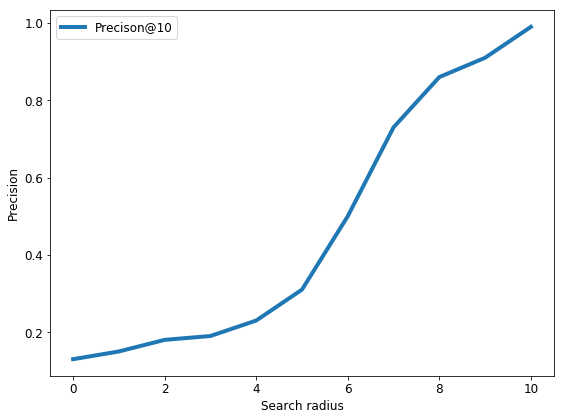

In [21]:
mean_precision = [np.mean(precision_history[i]) for i in range(len(precision_history))]

plt.figure()
plt.plot(mean_precision, linewidth=4, label='Precison@' + str(topn))
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()

# Conclusions
<hr style = "border:2px solid black" ></hr>


- LSH performs an efficient neighbor search by randomly partitioning all reference data points into different bins, when it comes to the similarity search stage, it will only consider searching within data points that fall within the same bin. 
- Then a radius parameter gives the end-user full control over the trade-off between the speed of the search versus the quality of the nearest neighbors.



# References
<hr style = "border:2px solid black" ></hr>


- [Coursera: Washington Clustering & Retrieval](https://www.coursera.org/learn/ml-clustering-and-retrieval)
- [Jupyter Notebook: Locality Sensitive Hashing](http://nbviewer.jupyter.org/github/smarthi/UnivOfWashington-Machine-Learning/blob/master/Clustering_IR/week2/1_nearest-neighbors-lsh-implementation_blank.ipynb)
- [Blog: Locality Sensitive Hashing for Similar Item Search](https://towardsdatascience.com/locality-sensitive-hashing-for-music-search-f2f1940ace23)
- [Blog: A Simple Content-Based Recommendation Engine in Python](http://blog.untrod.com/2016/06/simple-similar-products-recommendation-engine-in-python.html)
- [Stackoverflow: How to understand Locality Sensitive Hashing?](https://stackoverflow.com/questions/12952729/how-to-understand-locality-sensitive-hashing)

